In [87]:
!pip install chart_studio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [88]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
import requests
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, plot, iplot

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [89]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [90]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [91]:
data_dict = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_dict[filename] = os.path.join(dirname,filename)
        print(os.path.join(dirname, filename))
print(data_dict)

/kaggle/input/rona-img/rona4.jpeg
/kaggle/input/pipe-results/pipe_results.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
{'rona4.jpeg': '/kaggle/input/rona-img/rona4.jpeg', 'pipe_results.csv': '/kaggle/input/pipe-results/pipe_results.csv', 'Corona_NLP_train.csv': '/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', 'Corona_NLP_test.csv': '/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv'}


In [92]:
# Load in training data
train = pd.read_csv(data_dict['Corona_NLP_train.csv'], encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [93]:
# Load in test data
test_df = pd.read_csv(data_dict['Corona_NLP_test.csv'], encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## 2) Data Cleaning


In [94]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [95]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [96]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [97]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [98]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [99]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [100]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [101]:
tweet = df['newTweet'][1]
tweet

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [102]:
print(token_stem(tweet))
print('\n')
print(token_lemma(tweet))

advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order


advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order


In [103]:
df['stemTweet'] = df['newTweet'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = df['newTweet'].apply(lambda x: token_lemma(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...


In [104]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [105]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


In [106]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States', 'San Francisco',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD',
             'CA', 'FL', 'DC', 'TX', 'IL', 'MA', 'PA', 'GA', 'NC', 'NJ', 'WA', 'VA', 'PAK', 'MI', 'OH',
             'CO', 'AZ', 'D.C.', 'WI', 'MD', 'MO', 'TN', 'Florida', 'IN', 'NV', 'MN', 'OR','LA', 'Michigan',
             'CT', 'SC', 'OK', 'Illinois', 'Ohio', 'UT', 'KY', 'Arizona', 'Colorado')

# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', 'UK', 'Wales')
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia', 'Ontario', 'Victoria', 'British Columbia', 'Alberta',)
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
germany_filters = ('Germany', 'Deutschland')
switz_filters = ('Switzerland')
uae_filters = ('United Arab Emirates', 'Dubai')
spain_filters = ('Spain')
belg_filters = ('Belgium')
phil_filters = ('Philippines')
hk_filters = ('Hong Kong')
ghana_filters = ('Ghana')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [107]:
df['country'] = df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

In [108]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label,country
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0,London
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1,UK
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1,Vagabonds
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1,None
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1,None


In [109]:
# Changing strings found with filters into 3 digit codes
df['country'] = df['country'].apply(lambda x: 'USA' if x in us_filters else x)
df['country'] = df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['country'] = df['country'].apply(lambda x: 'IND' if x in india_filters else x)
df['country'] = df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['country'] = df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['country'] = df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['country'] = df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['country'] = df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['country'] = df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['country'] = df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
df['country'] = df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['country'] = df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['country'] = df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['country'] = df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['country'] = df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['country'] = df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
df['country'] = df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
df['country'] = df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
df['country'] = df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
df['country'] = df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
df['country'] = df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
df['country'] = df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
df['country'] = df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
df['country'] = df['country'].apply(lambda x: 'None' if x in other_filters else x)

In [110]:
df['country'].value_counts()

USA                               9675
None                              8980
GBR                               3811
CAN                               1233
IND                               1097
                                  ... 
Middlesex                            1
Helghan To Olympus By The Gods       1
The Resistance                       1
1 mile high (Denver)                 1
Paris France                         1
Name: country, Length: 7313, dtype: int64

In [111]:
# 0:24 because that's where the labeled countries end
places_df = pd.DataFrame(df['country'].value_counts()[0:30])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'country':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

In [112]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [113]:
iplot(choromap)

### The vast majority of tweets come from English speaking countries, which makes sense, since these tweets are all in English. Largest contributer is the USA followed by the UK and Canada.  


In [114]:
# image courtesy of https://tse2.mm.bing.net/th?id=OIP.VLv_PpEOc8TDwuTNvj5hWQHaHa&pid=Api
#img = Image.open(data_dict['rona4.jpeg'])
mask = np.array(Image.open(data_dict['rona4.jpeg']))

# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)

# Neutral WordCloud
neut_df = df[df['label'] == 0]
neut_text = neut_df['newTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Blues', mask = mask).generate(neut_text)

# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text)

(-0.5, 473.5, 473.5, -0.5)

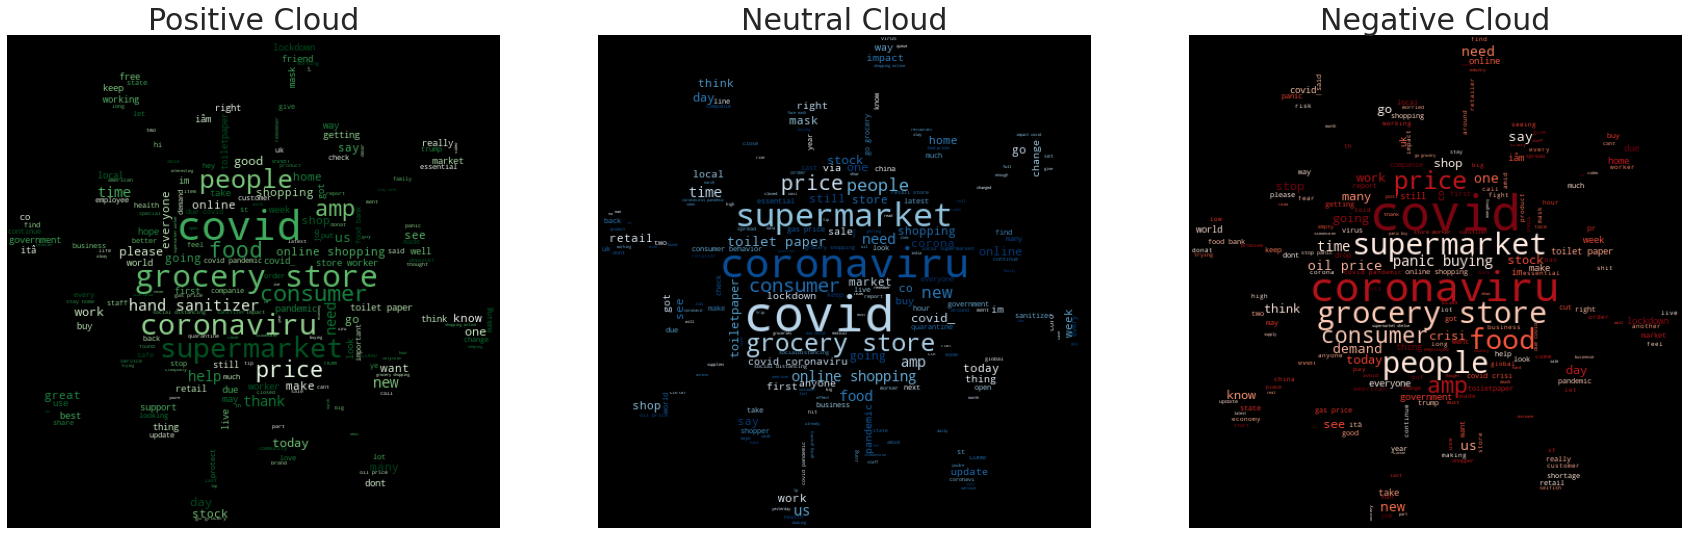

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Cloud', fontsize = 30)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Cloud', fontsize = 30)
ax3.axis('off')

Tried to use an image of the coronavirus for the mask, it certainly could have turned out better...
'Grocery store', 'price', 'supermarket', and 'online shopping' being frequent in positive, neutral, and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

In [116]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [117]:
unigram_df = ngram_df(df['newTweet'],(1,1),20)
bigram_df = ngram_df(df['newTweet'],(2,2),20)
trigram_df = ngram_df(df['newTweet'],(3,3),20)

In [118]:
unigram_df['text'][::-1]

19           time
18           like
17      sanitizer
16          panic
15        workers
14           need
13       pandemic
12         covid_
11         online
10       shopping
9        consumer
8             amp
7          people
6         grocery
5           store
4     supermarket
3            food
2          prices
1     coronavirus
0           covid
Name: text, dtype: object

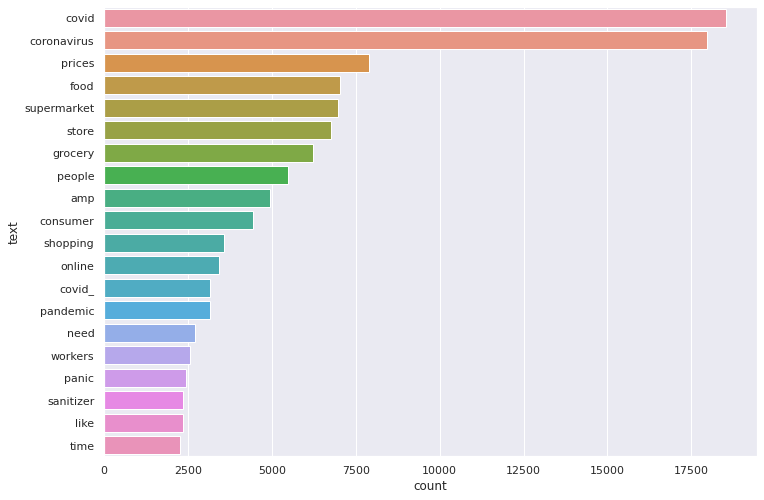

In [119]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = unigram_df, y = 'text', x = 'count')

### 'Prices' being the most frequent unigram after covid/coronavirus may be due to rising food prices and other various shortages.

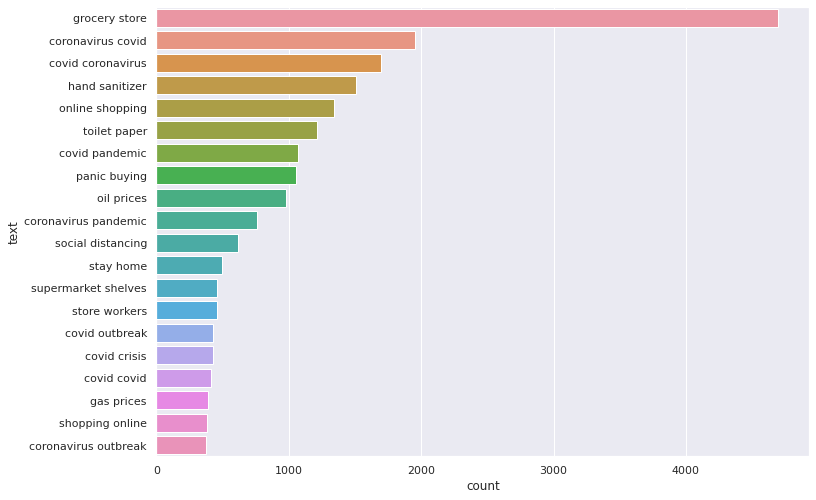

In [120]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = bigram_df, y = 'text', x = 'count')

### Grocery store way outpacing covid bigrams is pretty interesting. Online shopping, hand sanitizer, toilet paper, and panic buying are all within the realm of expectation. 

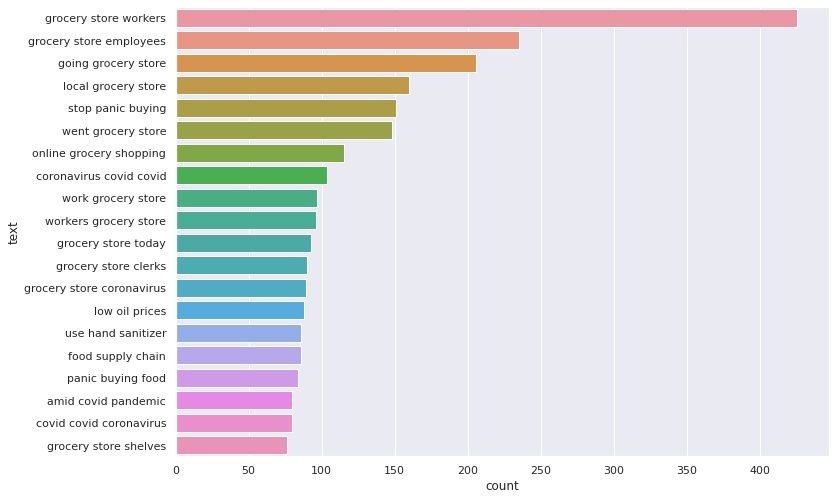

In [121]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = trigram_df, y = 'text', x = 'count')

### Grocery store dominates these trigrams. People may be concerned about the grocery store workers and their ability to safely shop at the supermarket during this pandemic.

## 4) Classification

In [122]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [123]:
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [124]:
def make_models(clf, vectorizer, X_train, y_train, cv = 5):
    
    acc_df = pd.DataFrame(index=range(cv * len(clf)))
    results = []
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                   ('clf', clf[classifier])])
        model.fit(X_train, y_train)
        scores = cross_val_score(model, X_train , y_train, cv = cv)
        model_name = classifier
        for fold, score in enumerate(scores):
            results.append((model_name, fold, score))
    
    acc_df = pd.DataFrame(results, columns=['model_name', 'fold', 'accuracy'])
    
    return acc_df

In [125]:
# Number of folds for K-fold cross validation
cv = 10

### Takes a good bit to run (over 30 minutes)...10 fold cross validation on 4 separate classifiers will take a while.
### Results are saved to 'pipe_results.csv' if you want to save time. 
### Logistic and RandomForest take much longer than SVC and NaiveBayes.

In [ ]:
tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df['method'] = 'none'
combined_df.head(10)

In [ ]:
# Set X and y.
X = df['stemTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

stem_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
stem_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

stem_tfidf_df['method'] = 'stem'
stem_tfidf_df['vectorizer'] = 'tfidf'
stem_count_df['method'] = 'stem'
stem_count_df['vectorizer'] = 'count'
stem_df = stem_tfidf_df.append(stem_count_df)

In [ ]:
# Set X and y.
X = df['lemmaTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lemma_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
lemma_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

lemma_tfidf_df['vectorizer'] = 'tfidf'
lemma_tfidf_df['method'] = 'lemma'
lemma_count_df['vectorizer'] = 'count'
lemma_count_df['method'] = 'lemma'
lemma_df = lemma_tfidf_df.append(lemma_count_df)

In [ ]:
all_df = lemma_df.append(stem_df)
all_df = all_df.append(combined_df)

In [126]:
# Skip to here to avoid running the models
all_df = pd.read_csv(data_dict['pipe_results.csv'])

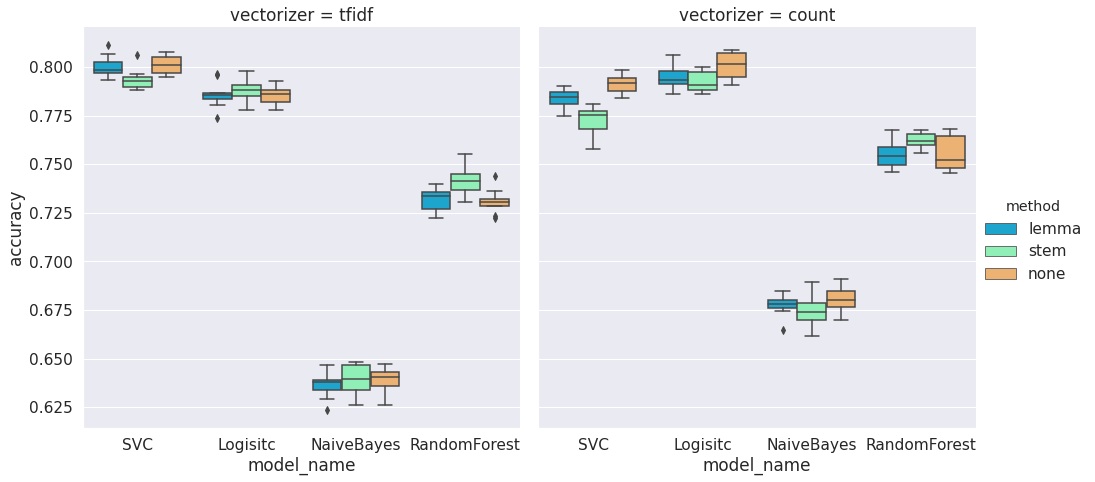

In [127]:
sns.set(font_scale = 1.4)
sns.catplot(x = 'model_name', y = 'accuracy', hue = 'method', height = 7,
            data = all_df, kind = 'box', col = 'vectorizer', palette = 'rainbow')

### Naive Bayes and RandomForest do much worse than Logistic and SVC, and make the boxplot fairly hard to look at. Let's drop them for better visuals. 

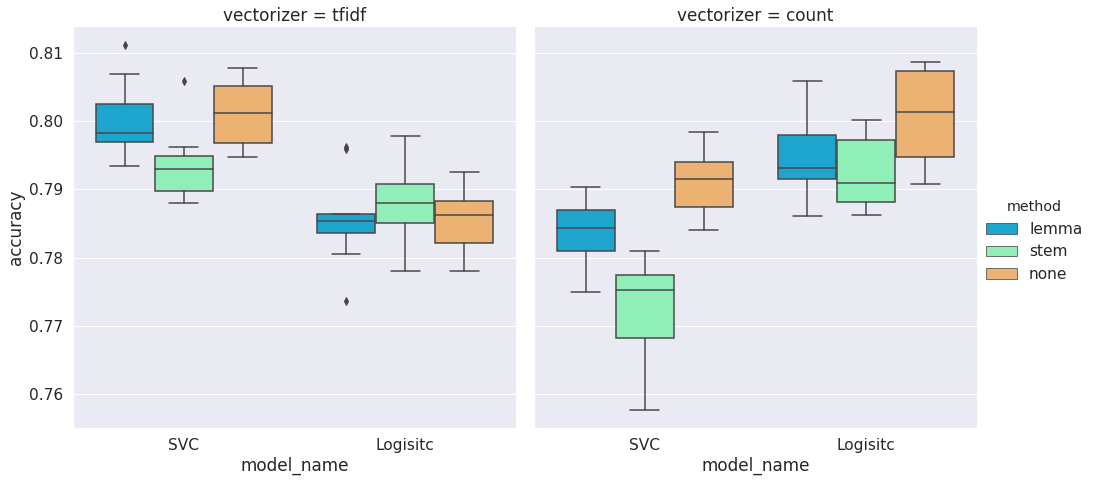

In [128]:
no_nb = all_df[all_df['model_name'] != 'NaiveBayes']
no_nb_rf = no_nb[no_nb['model_name'] != 'RandomForest']
sns.set(font_scale = 1.4)
sns.catplot(x = 'model_name', y = 'accuracy', hue = 'method', height = 7,
            data = no_nb_rf, kind = 'box', col = 'vectorizer', palette = 'rainbow')

### SVC does better when using tfidf, and Logistic Regression does better when using count. Stemming seems to do worse than lemmatization accuracy wise, although lemmatization has more outliers. The best results tend to come from using neither lemmatization nor stemming on the tweets. 
### SVC using tfidf and Logistic with count have approximately the same median, but the SVC has less variance and a slightly more even distribution. 
### It should be noted that the differences in accuracies between the best performing models are very small, and are probably due to the random splits more than methodology.  Bearing that in mind, I would select the LinearSVC using tfidf and no lemma/stem because it takes MUCH less time to run than the logistic regression, and based on these results, it has slightly less variance. 

In [129]:
#all_df = pd.read_csv('pipe_results.csv')

In [130]:
accuracies = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.mean()
stdDev = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.std()
metrics_df = pd.concat([accuracies, stdDev], axis = 1, ignore_index = True)
metrics_df.columns = ['mean_acc', 'mean_std']

In [131]:
metrics_df.sort_values(by = ['mean_acc','method'], ascending = False).head(10)

mean_acc  mean_std
model_name method vectorizer                    
SVC        none   tfidf       0.801002  0.004734
Logisitc   none   count       0.800789  0.006907
SVC        lemma  tfidf       0.800121  0.005521
Logisitc   lemma  count       0.794867  0.005839
SVC        stem   tfidf       0.793500  0.005246
Logisitc   stem   count       0.792316  0.005174
SVC        none   count       0.790827  0.004664
Logisitc   stem   tfidf       0.787547  0.006114
           lemma  tfidf       0.785786  0.006638
           none   tfidf       0.785361  0.004673

## Again, this displays just how small the accuracy differences are between the best models. For the sake of efficiency, an SVC using tfidf vectors is recommended. Let's fit one and explore the results more thorouhgly. 

In [132]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Set vectorizer for feature extraction.
vectorizer = TfidfVectorizer()

# Split data into training and test sets to fit the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define model for predictions
model = Pipeline([('vectorizer',vectorizer),
                  ('clf', LinearSVC(max_iter = 5000))])

model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', LinearSVC(max_iter=5000))])

In [133]:
train_preds = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, train_preds))
print('\n')
print(classification_report(y_test, train_preds))

Accuracy: 0.8077016520894071


              precision    recall  f1-score   support

          -1       0.82      0.82      0.82      3041
           0       0.72      0.66      0.69      1509
           1       0.83      0.86      0.85      3682

    accuracy                           0.81      8232
   macro avg       0.79      0.78      0.78      8232
weighted avg       0.81      0.81      0.81      8232



### ~81% accuracy on the training data, not too bad. Precision and recall are significantly lower for neutral tweets than positive or negative, possibly due to the lower support, but it could also be that neutral tweets are harder to classify. This model appears to be slightly better at predicting positive tweets than negative tweets. 
### Now, we'll see how the model performs on the test data.

In [134]:
# Set X and y.
X2 = test_df['newTweet']
y2 = test_df['label']


test_preds = model.predict(X2)
print('Accuracy:', accuracy_score(y2, test_preds))
print('\n')
print(classification_report(y2, test_preds))

Accuracy: 0.7904160084254871


              precision    recall  f1-score   support

          -1       0.80      0.81      0.81      1633
           0       0.71      0.61      0.66       619
           1       0.80      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.75      0.76      3798
weighted avg       0.79      0.79      0.79      3798



### Model does a little bit worse on test data than on training data. Let's see if we can improve the accuracy by tuning some parameters

In [135]:
# Dictionary of parameters that can be tuned
model.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()),
  ('clf', LinearSVC(max_iter=5000))],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'clf': LinearSVC(max_iter=5000),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__int

In [136]:
# GridSearchCV goes through specified parameter values and finds the best ones. 
from sklearn.model_selection import GridSearchCV

# We'll try a few different options here.
hyperparameters = { 'vectorizer__max_df': [1, 0.9, 0.95, .85],
                    'vectorizer__ngram_range': [(1,1), (1,2), (2,2),(2,3)],
                  }
model_tune = GridSearchCV(model, hyperparameters, cv=5)

# Fit and tune model
model_tune.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', LinearSVC(max_iter=5000))]),
             param_grid={'vectorizer__max_df': [1, 0.9, 0.95, 0.85],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                     (2, 3)]})

In [137]:
# These are the best parameters according to the GridSearch
model_tune.best_params_

{'vectorizer__max_df': 0.9, 'vectorizer__ngram_range': (1, 1)}

In [138]:
# Gridsearch will refit the model on the best settings
model_tune.refit

True

In [139]:
preds = model_tune.predict(X2)
print('Accuracy:', accuracy_score(y2, preds))
print('\n')
print(classification_report(y2, preds))

Accuracy: 0.7904160084254871


              precision    recall  f1-score   support

          -1       0.80      0.81      0.81      1633
           0       0.71      0.61      0.66       619
           1       0.80      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.75      0.76      3798
weighted avg       0.79      0.79      0.79      3798



### Looks like our tuning didn't change anything at all.  Let's take a look at some of the mislabled tweets.

In [140]:
test_df['pred_label'] = test_preds
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,label,pred_label
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,-1,-1
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer fred meyer ...,1,1
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find protect loved ones coronavirus,1,1
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city anxious shopper...,-1,-1
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...,0,0


In [141]:
mislabel_df = test_df[test_df['label'] != test_preds]
mislabel_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,label,pred_label
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We canÂt stop #COVID19 without pro...",Neutral,we canât stop covid without protecting healthw...,0,-1
15,16,44968,Bengaluru,04-03-2020,#AirSewa \r\r\n\r\r\n@flyspicejet is not provi...,Extremely Negative,airsewa providing webchecin customers free sea...,-1,1
27,28,44980,NaN,07-03-2020,Coronavirus panic spreads: Costco is pulling f...,Negative,coronavirus panic spreads costco pulling free ...,-1,1
34,35,44987,"Angmering, West Sussex",08-03-2020,So not due to #Brexit at all then &gt;&gt; Sup...,Neutral,so due brexit gtgt supermarkets begin foodrati...,0,-1
37,38,44990,NaN,08-03-2020,@howroute ItÂs not even over food... what the...,Neutral,itâs even food actual heck i news people need ...,0,-1


In [142]:
mislabel_df['Location'].fillna('None', inplace = True)
mislabel_df['country'] = mislabel_df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

# Changing strings found with filters into 3 digit codes
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'USA' if x in us_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'IND' if x in india_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
mislabel_df['country'] = mislabel_df['country'].apply(lambda x: 'None' if x in other_filters else x)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [143]:
mislabel_df['country'].value_counts()

USA                     204
None                    198
GBR                      51
CAN                      34
IRL                      12
                       ... 
California ?              1
Greece                    1
South Staffordshire       1
In the Ether              1
Lebanon                   1
Name: country, Length: 246, dtype: int64

### The mislabels mostly come from the USA, which is where the majority of the tweets are from anyway. Let's take a look at a few of the tweets themselves.

In [153]:
mislabel_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,label,pred_label,country
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We canÂt stop #COVID19 without pro...",Neutral,we canât stop covid without protecting healthw...,0,-1,CHE
15,16,44968,Bengaluru,04-03-2020,#AirSewa \r\r\n\r\r\n@flyspicejet is not provi...,Extremely Negative,airsewa providing webchecin customers free sea...,-1,1,Bengaluru
27,28,44980,None,07-03-2020,Coronavirus panic spreads: Costco is pulling f...,Negative,coronavirus panic spreads costco pulling free ...,-1,1,None
34,35,44987,"Angmering, West Sussex",08-03-2020,So not due to #Brexit at all then &gt;&gt; Sup...,Neutral,so due brexit gtgt supermarkets begin foodrati...,0,-1,West Sussex
37,38,44990,None,08-03-2020,@howroute ItÂs not even over food... what the...,Neutral,itâs even food actual heck i news people need ...,0,-1,None


In [154]:
mislabel_df.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,label,pred_label,country
3770,3771,48723,"West Virginia, USA",16-03-2020,"PSA: Stop panicking about COVID-19, you don't ...",Negative,psa stop panicking covid dont need shelter out...,-1,1,USA
3771,3772,48724,"Houston, TX",16-03-2020,When I'm stopped by George at the grocery stor...,Negative,when im stopped george grocery store should i ...,-1,0,USA
3778,3779,48731,None,16-03-2020,In light of the ongoing and rapidly evolving C...,Neutral,in light ongoing rapidly evolving covid pandem...,0,1,None
3779,3780,48732,None,16-03-2020,Stuck inside? How about getting some reading ...,Positive,stuck inside how getting reading fill time min...,1,-1,None
3788,3789,48741,Pakistan,16-03-2020,You never eaten the pigs cat dog or food from ...,Neutral,you never eaten pigs cat dog food internationa...,0,-1,PAK


In [145]:
# Neutral tweet
print(mislabel_df['OriginalTweet'][7])
print('\n')
print(mislabel_df['newTweet'][7])


Prices of surgical masks have increased six-fold, N95 respirators have more than trebled &amp; gowns cost twice as much"-@DrTedros #coronavirus


we canât stop covid without protecting healthworkers prices surgical masks increased sixfold n respirators trebled amp gowns cost twice much coronavirus


### Wonder how that mark above the 'A' affected the predicted label, and other marked words. 

In [146]:
# Negative tweet
print(mislabel_df['OriginalTweet'][15])
print('\n')
print(mislabel_df['newTweet'][15])









@HardeepSPuri @MoCA_GoI


airsewa providing webchecin customers free seats passengers forced choose paid seats free seats made available airport counter this stopped itâs discriminatory travellers rights


### Here the model predicted positive, and the 'Â' showed up again in a mislabel. The model may have seen 'free' and 'rights' and labeled it as positive, even though to a human reader, this quite clearly a very negative tweet.

In [150]:
# Positive tweet
print(mislabel_df['OriginalTweet'][3779])
print('\n')
print(mislabel_df['newTweet'][3779])

Stuck inside?  How about getting some reading in to fill the time, and your mind?  For the #coronavirus #COVID?19 time, I've lowered all ebook prices to $0.99.  Comedy, drama, action, philosophy, romance, your choice.  https://t.co/Qd67Hf6BfZ


stuck inside how getting reading fill time mind for coronavirus covid time ive lowered ebook prices comedy drama action philosophy romance choice


### The model predicted negative for this tweet, while the true label is positive. Lower prices is indeed a positive thing for consumers. Perhaps the model took 'stuck', 'coronavirus', and 'covid' to be more negative than the other words in the tweet.

### A possible update to improve accuracy of this model may involve handling the accented letters in a better way. 
### However, if we want better accuracy, we should try BERT. We'll fit a BERT model and see how well it does.

# 5) BERT

In [ ]:
#!pip install transformers

In [155]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

from torch.utils.data import TensorDataset

import transformers
from transformers import BertForSequenceClassification

#import numpy as np
#import pandas as pd
#import re

In [156]:
from sklearn.preprocessing import LabelEncoder

# Encode the classes for BERT. We'll keep using the 3 labels we made earlier.  
encoder = LabelEncoder()
df['encoded_sentiment'] = encoder.fit_transform(df['label'])

In [157]:
# Set X and y.
X = df['newTweet']
y = df['encoded_sentiment']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [158]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [159]:
# Encoding the words in the training data into vectors.
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    truncation = True,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

# Encoding the words in the test data into vectors.
encoded_data_test = tokenizer.batch_encode_plus(
    X_test, 
    truncation = True,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

In [160]:
# Get inputs and attention masks from previously encoded data. 
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(y_test.values)

# Instantiate TensorDataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [161]:
# Initialize the model. 
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [162]:
# DataLoaders for running the model
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=128)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=128)

In [163]:
# Setting hyperparameters
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [164]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [165]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda')

In [166]:
model.to(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')



Epoch 1
Training loss: 0.7448670484067857



Epoch 2
Training loss: 0.494678303252819



Epoch 3
Training loss: 0.4070914802971736



Epoch 4
Training loss: 0.3546899179386538



Epoch 5
Training loss: 0.31486670060675276



Epoch 6
Training loss: 0.28397538703541425



Epoch 7
Training loss: 0.2611888955787633



Epoch 8
Training loss: 0.2446633950453396



Epoch 9
Training loss: 0.23155597516501597



Epoch 10
Training loss: 0.2230078365740388



In [167]:
def evaluate(dataloader_test):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_test:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_test) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [168]:
val_loss, predictions, true_vals = evaluate(dataloader_test)
val_f1 = f1_score_func(predictions, true_vals)

In [169]:
print('Val Loss = ', val_loss)
print('Val F1 = ', val_f1)

Val Loss =  0.41119183072677024
Val F1 =  0.8722559138481192


In [170]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

In [171]:
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.8729348882410107


In [172]:
print(classification_report(true_category, predicted_category))

              precision    recall  f1-score   support

          -1       0.87      0.89      0.88      3050
           0       0.87      0.77      0.82      1529
           1       0.88      0.90      0.89      3653

    accuracy                           0.87      8232
   macro avg       0.87      0.85      0.86      8232
weighted avg       0.87      0.87      0.87      8232



### 87% accuracy is about 6% better than what we get using an SVC for training. 

## Use the test dataset to evaluate model.

In [173]:
test_df['encoded_sentiment'] = encoder.fit_transform(test_df['label'])

# Set X and y.
X = test_df['newTweet']
y = test_df['encoded_sentiment']

encoded_data_test = tokenizer.batch_encode_plus(
    X, 
    truncation = True,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(y.values)

# Pytorch TensorDataset Instance
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=128)

In [174]:
val_loss, predictions, true_vals = evaluate(dataloader_test)
val_f1 = f1_score_func(predictions, true_vals)

In [175]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))
print('\n')
print(classification_report(true_category, predicted_category))

Accuracy Score =  0.8554502369668247


              precision    recall  f1-score   support

          -1       0.84      0.88      0.86      1633
           0       0.85      0.76      0.80       619
           1       0.87      0.87      0.87      1546

    accuracy                           0.86      3798
   macro avg       0.86      0.84      0.84      3798
weighted avg       0.86      0.86      0.85      3798



### On the actual test data, the model score an 85%, which is ~5% better than the LinearSVC performed on this data. This BERT model could possibly squeeze out some more accuracy with more hyperparameter tuning, as I did not play around with the learning rate. It is not surprising that BERT performs better than a simple LinearSVC.

A big thank you to all these notebooks:

https://www.kaggle.com/immvab/transformers-covid-19-tweets-sentiment-analysis/comments

https://www.kaggle.com/arushi2/covid19-tweets-geo-and-sentiment-analysis#data

https://www.kaggle.com/datatattle/battle-of-ml-classification-models

https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

